In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/house-prices-advanced-regression-techniques/sample_submission.csv
/kaggle/input/house-prices-advanced-regression-techniques/data_description.txt
/kaggle/input/house-prices-advanced-regression-techniques/train.csv
/kaggle/input/house-prices-advanced-regression-techniques/test.csv


In [2]:
import seaborn as sns
import matplotlib.pyplot as plt

# read data
train_df = pd.read_csv('/kaggle/input/house-prices-advanced-regression-techniques/train.csv')
test_df = pd.read_csv('/kaggle/input/house-prices-advanced-regression-techniques/test.csv')

# Data Overview
print("Number of rows and columns in the training data:", train_df.shape)
train_df.info()

Number of rows and columns in the training data: (1460, 81)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   objec

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


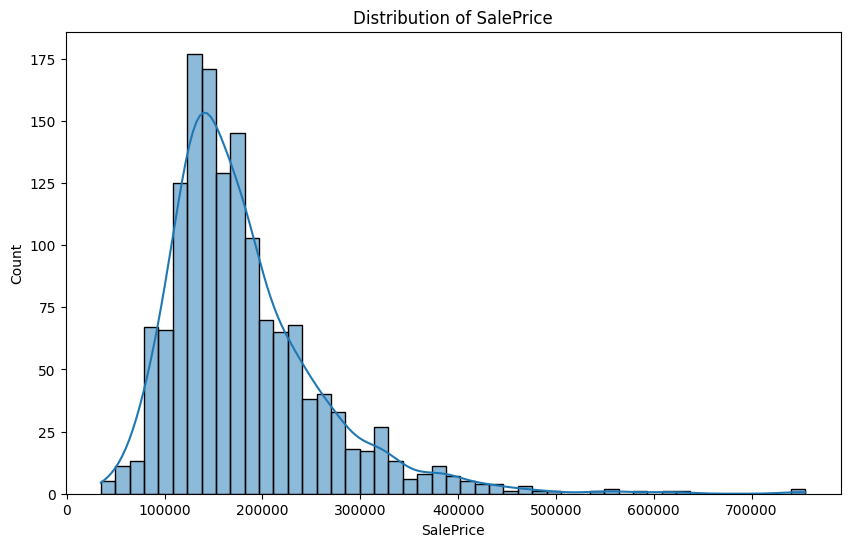

In [3]:
# Histogram of SalesPrice
plt.figure(figsize=(10, 6))
sns.histplot(train_df['SalePrice'], kde=True)
plt.title('Distribution of SalePrice')
plt.show()

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


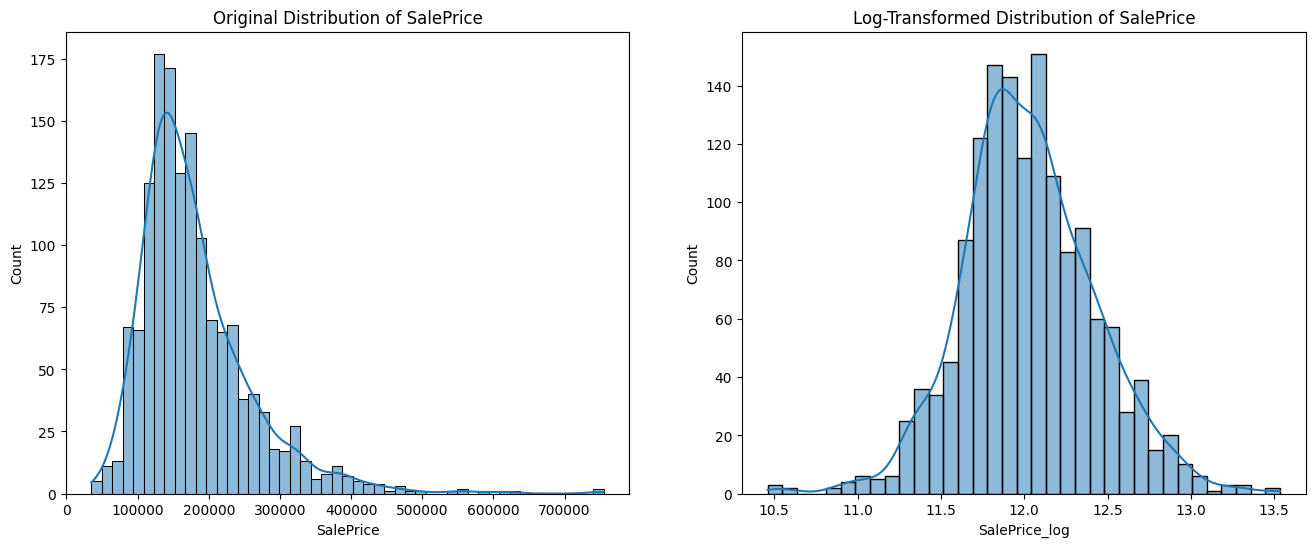

In [4]:
# Apply a log transformation to SalePrice
# We use np.log1p() which calculates log(1+x) to handle potential zero values gracefully
train_df['SalePrice_log'] = np.log1p(train_df['SalePrice'])

# Create a figure with two subplots to compare
fig, ax = plt.subplots(1, 2, figsize=(16, 6))

# Original distribution
sns.histplot(train_df['SalePrice'], kde=True, ax=ax[0])
ax[0].set_title('Original Distribution of SalePrice')

# Log-transformed distribution
sns.histplot(train_df['SalePrice_log'], kde=True, ax=ax[1])
ax[1].set_title('Log-Transformed Distribution of SalePrice')

plt.show()

In [5]:
# Calculate the percentage of missing values in each column
missing_ratio = train_df.isnull().sum() / len(train_df)
missing_ratio = missing_ratio[missing_ratio > 0].sort_values(ascending=False)

# Display the percentage of missing values
print(missing_ratio)

PoolQC          0.995205
MiscFeature     0.963014
Alley           0.937671
Fence           0.807534
MasVnrType      0.597260
FireplaceQu     0.472603
LotFrontage     0.177397
GarageType      0.055479
GarageYrBlt     0.055479
GarageFinish    0.055479
GarageQual      0.055479
GarageCond      0.055479
BsmtFinType2    0.026027
BsmtExposure    0.026027
BsmtFinType1    0.025342
BsmtCond        0.025342
BsmtQual        0.025342
MasVnrArea      0.005479
Electrical      0.000685
dtype: float64


In [6]:
# Drop columns with too many missing values
train_df = train_df.drop(columns=['PoolQC', 'MiscFeature', 'Alley', 'Fence', 'FireplaceQu'])
test_df = test_df.drop(columns=['PoolQC', 'MiscFeature', 'Alley', 'Fence', 'FireplaceQu'])

# Fill missing values in categorical variables with 'None'
# e.g., Garage-related columns
for col in ['GarageType', 'GarageFinish', 'GarageQual', 'GarageCond']:
    train_df[col] = train_df[col].fillna('None')
    test_df[col] = test_df[col].fillna('None')

# Fill missing values in numerical variables with the median
# e.g., LotFrontage (Linear feet of street connected to property)
lot_frontage_median = train_df['LotFrontage'].median()
train_df['LotFrontage'] = train_df['LotFrontage'].fillna(lot_frontage_median)
test_df['LotFrontage'] = test_df['LotFrontage'].fillna(lot_frontage_median)

# Check the number of missing values after processing
print("\nNumber of missing values in training data after processing:")
print(train_df.isnull().sum().sum())


Number of missing values in training data after processing:
1149


In [7]:
# Fill missing values in basement-related categorical variables with 'None'
for col in ['BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2']:
    train_df[col] = train_df[col].fillna('None')
    test_df[col] = test_df[col].fillna('None')

# Handle other potentially remaining missing values
# For 'Electrical', it's common to fill with the mode
electrical_mode = train_df['Electrical'].mode()[0]
train_df['Electrical'] = train_df['Electrical'].fillna(electrical_mode)

# Fill missing values that exist only in the test data using the median or mode of each column
test_df['MSZoning'] = test_df['MSZoning'].fillna(test_df['MSZoning'].mode()[0])
test_df['Utilities'] = test_df['Utilities'].fillna(test_df['Utilities'].mode()[0])
test_df['Exterior1st'] = test_df['Exterior1st'].fillna(test_df['Exterior1st'].mode()[0])
test_df['Exterior2nd'] = test_df['Exterior2nd'].fillna(test_df['Exterior2nd'].mode()[0])
test_df['BsmtFinSF1'] = test_df['BsmtFinSF1'].fillna(test_df['BsmtFinSF1'].median())
test_df['BsmtFinSF2'] = test_df['BsmtFinSF2'].fillna(test_df['BsmtFinSF2'].median())
test_df['BsmtUnfSF'] = test_df['BsmtUnfSF'].fillna(test_df['BsmtUnfSF'].median())
test_df['TotalBsmtSF'] = test_df['TotalBsmtSF'].fillna(test_df['TotalBsmtSF'].median())
test_df['BsmtFullBath'] = test_df['BsmtFullBath'].fillna(test_df['BsmtFullBath'].mode()[0])
test_df['BsmtHalfBath'] = test_df['BsmtHalfBath'].fillna(test_df['BsmtHalfBath'].mode()[0])
test_df['KitchenQual'] = test_df['KitchenQual'].fillna(test_df['KitchenQual'].mode()[0])
test_df['Functional'] = test_df['Functional'].fillna(test_df['Functional'].mode()[0])
test_df['GarageCars'] = test_df['GarageCars'].fillna(test_df['GarageCars'].median())
test_df['GarageArea'] = test_df['GarageArea'].fillna(test_df['GarageArea'].median())
test_df['SaleType'] = test_df['SaleType'].fillna(test_df['SaleType'].mode()[0])

# Most missing values should be handled by now
# Let's check the count of missing values again
print("Total remaining missing values in training data:", train_df.isnull().sum().sum())
print("Total remaining missing values in test data:", test_df.isnull().sum().sum())

Total remaining missing values in training data: 961
Total remaining missing values in test data: 987


In [8]:
# Combine training and test data to process them at once
all_df = pd.concat([train_df.drop('SalePrice_log', axis=1), test_df], sort=False)

# Apply One-Hot Encoding
# This converts categorical columns into multiple new columns represented by 0s and 1s.
all_df = pd.get_dummies(all_df)

# --- ADD THIS NEW STEP ---
all_df_imputed = all_df.fillna(all_df.median())
print("Number of remaining NaNs after this new step:", all_df_imputed.isnull().sum().sum())
# --- NEW STEP ENDS ---

# Split the data back into train and test sets
train_processed_df = all_df_imputed[:len(train_df)]
test_processed_df = all_df_imputed[len(train_df):]

print("Number of columns in training data after One-Hot Encoding:", train_processed_df.shape[1])

Number of remaining NaNs after this new step: 0
Number of columns in training data after One-Hot Encoding: 280


In [9]:
from sklearn.linear_model import Ridge
from sklearn.model_selection import cross_val_score
import numpy as np

# --- 1. Data Preparation ---
# X is all features, y is the log-transformed price
X_train = train_processed_df
y_train = train_df['SalePrice_log'] # Use the log-transformed target

# Prepare the test data as well
X_test = test_processed_df

# --- 2. Model Preparation and Cross-Validation ---
# Prepare the Ridge regression model
# alpha is the regularization parameter that controls model complexity
model = Ridge(alpha=10)

# Estimate the model's performance with cross-validation
# For regression problems, it's common to use 'neg_mean_squared_error' as the evaluation metric
scores = cross_val_score(model, X_train, y_train, cv=5, scoring='neg_mean_squared_error')
rmse_scores = np.sqrt(-scores) # Convert the scores to RMSE (Root Mean Squared Error)

print("RMSE scores from cross-validation:", rmse_scores)
print("Average RMSE score:", np.mean(rmse_scores))


# --- 3. Retrain the model on all training data and make predictions ---
model.fit(X_train, y_train)
predictions_log = model.predict(X_test)

# --- 4. Transform predictions back to the original price scale ---
# Since we predicted the log-transformed values, we need to convert them back
predictions = np.expm1(predictions_log)

# --- 5. Create the submission file ---
submission = pd.DataFrame({
    "Id": test_df["Id"],
    "SalePrice": predictions
})
submission.to_csv('submission_house_prices.csv', index=False)

print("\nsubmission_house_prices.csv file has been created successfully!")

RMSE scores from cross-validation: [0.07371041 0.08629857 0.08988716 0.08121171 0.08925601]
Average RMSE score: 0.08407277391993749

submission_house_prices.csv file has been created successfully!
